<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Denoising using Autoencoder and PCA
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Tasks
<hr/>

1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Visualize original images, their corresponding noisy images and their reconstructed versions side by side.
4. Repeat the previous steps using PCA algorithm.

# Import Necessary Libraries

In [1]:
# Importing required libraries
import torch                       # PyTorch for building neural networks
import torch.nn as nn              # PyTorch neural network module
import torch.optim as optim        # Optimizer for gradient descent
import torch.utils.data as data    # Utilities for dataset handling
from torch.utils.data import DataLoader, Dataset  # For data loading and custom datasets

# Importing torchvision libraries for dataset and transformations
import torchvision
import torchvision.transforms as transforms  # For transforming images
from torchvision.datasets import MNIST      # MNIST dataset

# Importing additional libraries
import numpy as np                         # For numerical computations
import matplotlib.pyplot as plt            # For plotting images
from sklearn.decomposition import PCA      # For Principal Component Analysis
from sklearn.datasets import fetch_openml  # For fetching datasets

# Importing TensorFlow
import tensorflow as tf                    # TensorFlow library (used elsewhere in the code)

# Load Dataset and Prepare It

In [2]:
class NoisyMNIST(Dataset):
    """ 
    Custom Dataset class that adds noise to MNIST images.
    
    Attributes:
        dataset: The original MNIST dataset.
        noise_factor: A float representing the intensity of the noise added to the images.
    """
    
    def __init__(self, dataset, noise_factor=0.5):
        """
        Initializes the NoisyMNIST dataset.

        Args:
            dataset: The original dataset (e.g., MNIST) from which to create noisy images.
            noise_factor: The standard deviation of the noise to be added (default is 0.5).
        """
        self.dataset = dataset  # Store the original dataset
        self.noise_factor = noise_factor  # Store the noise factor

    def __len__(self):
        """
        Returns the size of the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.dataset)  # Return the length of the original dataset

    def __getitem__(self, index):
        """
        Retrieves a noisy image and its corresponding original image by index.

        Args:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the noisy image and the original image.
        """
        # Retrieve the original image and its label from the dataset
        image, label = self.dataset[index]
        
        # Add random noise to the image
        noisy_image = image + self.noise_factor * torch.randn_like(image)
        
        # Clip the noisy image to ensure pixel values remain in the range [0, 1]
        noisy_image = torch.clamp(noisy_image, 0., 1.)
        
        # Return both the noisy image and the original image
        return noisy_image, image


# Load MNIST data
transform = transforms.ToTensor()  # Transformation to convert images to tensors

# Creating the training dataset for MNIST
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Creating the test dataset for MNIST
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15787137.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 471266.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4388637.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2419114.76it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Create noisy dataset
train_noisy_dataset = NoisyMNIST(train_dataset)
test_noisy_dataset = NoisyMNIST(test_dataset)

# Create data loaders
train_loader = DataLoader(train_noisy_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_noisy_dataset, batch_size=64, shuffle=False)

# Define Your Model
torch neural network model

In [4]:
class AutoEncoder(nn.Module):
    """
    AutoEncoder class for compressing and reconstructing images.
    
    This class implements an autoencoder using convolutional layers
    to encode the input images into a compressed representation and 
    then decode them back to the original image dimensions.
    """
    
    def __init__(self):
        """
        Initializes the AutoEncoder model architecture.
        
        The architecture consists of an encoder that compresses the input images
        and a decoder that reconstructs the images from the compressed representation.
        """
        super(AutoEncoder, self).__init__()  # Call the parent class constructor
        
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Convolutional layer: input channels=1, output channels=16
            # Output size: 16 feature maps of size 14x14
            nn.ReLU(),  # Activation function introducing non-linearity
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Second convolutional layer: input channels=16, output channels=32
            # Output size: 32 feature maps of size 7x7
            nn.ReLU(),  # Activation function
            nn.Conv2d(32, 64, 7)  # Third convolutional layer: input channels=32, output channels=64
            # Output size: 64 feature maps of size 1x1
        )
        
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # Transposed convolutional layer: input channels=64, output channels=32
            # Output size: 32 feature maps of size 7x7
            nn.ReLU(),  # Activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Second transposed layer
            # Output size: 16 feature maps of size 14x14
            nn.ReLU(),  # Activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # Final transposed layer
            # Output size: 1 feature map of size 28x28
            nn.Sigmoid()  # Sigmoid activation to ensure output values are between 0 and 1
        )

    def forward(self, x):
        """
        Defines the forward pass of the autoencoder.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            Tensor: The reconstructed output tensor from the decoder.
        """
        encoded = self.encoder(x)  # Pass the input through the encoder
        decoded = self.decoder(encoded)  # Pass the encoded representation through the decoder
        return decoded  # Return the reconstructed output

In this implementation, the encoder consists of two fully connected layers with ReLU activation functions, which reduce the input data from the original 28$\times$28 size to a 64-dimensional representation. The decoder then consists of two fully connected layers with ReLU and sigmoid activation functions, which expand the 64-dimensional representation back to the original 28$\times$28 size.

The forward method of the AutoEncoder class takes the input x and passes it through the encoder and decoder to obtain the reconstructed output.

# Fit The Model
Also Define optimizer, Criterion and other parameters

In [5]:
# Initialize model, loss function, and optimizer
# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the AutoEncoder model and move it to the specified device (GPU or CPU)
model = AutoEncoder().to(device)

# Define the loss function as Mean Squared Error (MSE) Loss, suitable for regression tasks
criterion = nn.MSELoss()

# Set up the Adam optimizer to update model parameters, with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the AutoEncoder
num_epochs = 10  # Number of epochs to train the model

# Loop over the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (enables dropout, batch normalization, etc.)
    
    train_loss = 0  # Initialize the training loss for this epoch
    
    # Iterate over the training data loader
    for noisy_imgs, clean_imgs in train_loader:
        # Move the noisy and clean images to the specified device
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        
        # Zero the gradients from the previous step
        optimizer.zero_grad()
        
        # Pass the noisy images through the model to get reconstructed outputs
        outputs = model(noisy_imgs)
        
        # Calculate the loss by comparing the model's outputs with the clean images
        loss = criterion(outputs, clean_imgs)
        
        # Backpropagate the loss to compute gradients
        loss.backward()
        
        # Update the model parameters using the optimizer
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item()

    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader)}')

Epoch 1/10, Loss: 0.042760313333653564
Epoch 2/10, Loss: 0.016171576227865685
Epoch 3/10, Loss: 0.013509739218140715
Epoch 4/10, Loss: 0.012495487829102382
Epoch 5/10, Loss: 0.011930131137982677
Epoch 6/10, Loss: 0.011585217677175935
Epoch 7/10, Loss: 0.011356225358381836
Epoch 8/10, Loss: 0.011168119092501684
Epoch 9/10, Loss: 0.011038508664355922
Epoch 10/10, Loss: 0.010882297966645154


In this model, the reconstruction loss is minimized using the mean squared error (MSE) loss between the original input data and the reconstructed output data. The MSE loss measures the average squared difference between the original and reconstructed data and is a common choice for our autoencoder model.

During training, the model takes an input data point, passes it through the encoder to obtain a compressed representation, and then passes the compressed representation through the decoder to obtain the reconstructed output. The MSE loss between the original input data and the reconstructed output data is then computed and used to update the model's parameters through backpropagation.

The optimization algorithm used to update the model's parameters is typically stochastic gradient descent (SGD) or one of its variants such as Adam. The goal of the optimization algorithm is to find the set of parameters that minimize the reconstruction loss over the training set.

# Plot The Results

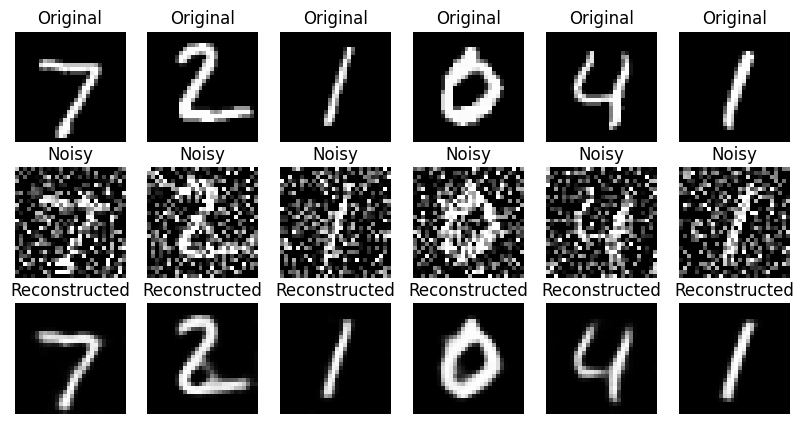

In [6]:
def show_images(original, noisy, reconstructed):
    """
    Visualizes original, noisy, and reconstructed images in a grid format.

    Args:
        original (Tensor): Original clean images.
        noisy (Tensor): Noisy images generated from the original images.
        reconstructed (Tensor): Images reconstructed by the autoencoder from the noisy images.
    """
    # Create a figure with a grid of subplots (3 rows for original, noisy, and reconstructed images)
    fig, axes = plt.subplots(3, 6, figsize=(10, 5))
    
    # Loop through the first 6 images to display
    for i in range(6):
        # Display the original image in the first row
        axes[0, i].imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        
        # Display the noisy image in the second row
        axes[1, i].imshow(noisy[i].squeeze().cpu().numpy(), cmap='gray')
        
        # Display the reconstructed image in the third row
        axes[2, i].imshow(reconstructed[i].squeeze().cpu().detach().numpy(), cmap='gray')
        
        # Set titles for each row
        axes[0, i].set_title('Original')
        axes[1, i].set_title('Noisy')
        axes[2, i].set_title('Reconstructed')
        
        # Turn off the axis for all images for better visualization
        for ax in axes[:, i]:
            ax.axis('off')  # Hide the axis ticks and labels
    
    # Display the plot with all images
    plt.show()

# Get some images from the test set and visualize them
model.eval()  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)

# Use torch.no_grad() to prevent gradient calculations during inference
with torch.no_grad():
    # Get a batch of noisy and clean images from the test data loader
    noisy_imgs, clean_imgs = next(iter(test_loader))
    
    # Move the images to the specified device (GPU or CPU)
    noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
    
    # Pass the noisy images through the model to obtain reconstructed images
    reconstructed_imgs = model(noisy_imgs)
    
    # Call the show_images function to display the original, noisy, and reconstructed images
    show_images(clean_imgs, noisy_imgs, reconstructed_imgs)

# PCA

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


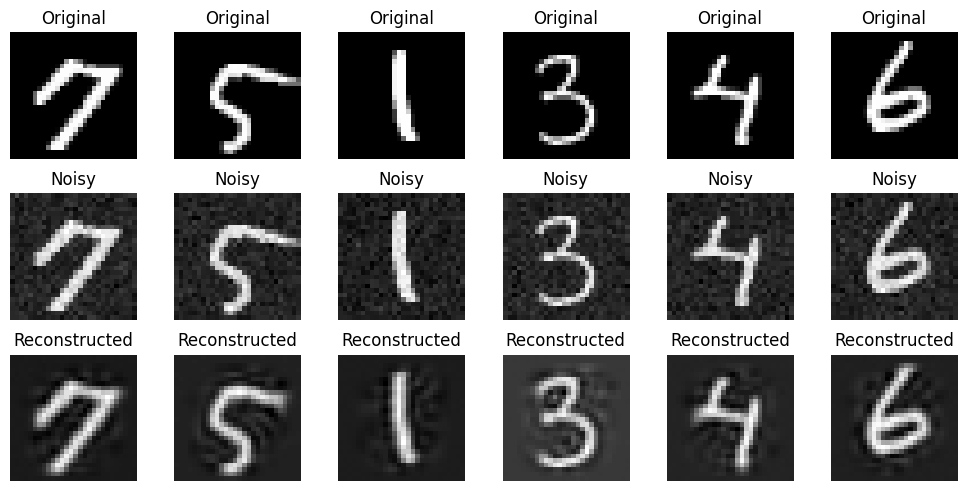

In [7]:
# Load the MNIST dataset
# The MNIST dataset consists of images of handwritten digits (0 to 9)
mnist = tf.keras.datasets.mnist  # Accessing the MNIST dataset through TensorFlow
(X_train, _), (X_test, _) = mnist.load_data()  # Load the training and testing data, ignoring labels

# Flatten the image data
# Each image in MNIST is 28x28 pixels, so we reshape it to a 1D array of 784 pixels
X_train = X_train.reshape(-1, 28 * 28)  # Flatten the training images into 1D arrays
X_test = X_test.reshape(-1, 28 * 28)  # Flatten the testing images into 1D arrays

# Add Gaussian noise to the datasets
noise_stddev = 15  # Define the standard deviation for the Gaussian noise to be added

# Generate Gaussian noise and add it to the training and testing images
X_train_noisy = X_train + np.random.normal(scale=noise_stddev, size=X_train.shape)  # Add noise to training images
X_test_noisy = X_test + np.random.normal(scale=noise_stddev, size=X_test.shape)  # Add noise to testing images

# Denoise the datasets using PCA
n_components = 0.9  # Set the proportion of variance to retain in PCA

# Fit PCA on the noisy training set
pca = PCA(n_components=n_components)  # Initialize PCA with the desired number of components
pca.fit(X_train_noisy)  # Fit PCA on the noisy training data to learn the principal components

# Denoise the training and testing sets using the fitted PCA model
# Transform the noisy data into the PCA space and then inverse transform to recover denoised data
X_train_denoised = pca.inverse_transform(pca.transform(X_train_noisy))  # Denoise training images
X_test_denoised = pca.inverse_transform(pca.transform(X_test_noisy))  # Denoise testing images

def show_images(original, noisy, reconstructed, num_images=5):
    """
    Visualizes original, noisy, and reconstructed images in a grid format.

    Args:
        original (ndarray): Original clean images.
        noisy (ndarray): Noisy images generated from the original images.
        reconstructed (ndarray): Denoised images obtained from PCA.
        num_images (int): Number of images to display (default is 5).
    """
    # Create a figure with a grid of subplots (3 rows for original, noisy, and reconstructed images)
    fig, axes = plt.subplots(3, num_images, figsize=(10, 5))
    
    # Loop through the specified number of images to display
    for i in range(num_images):
        # Display the original image in the first row
        axes[0, i].imshow(original[i].reshape(28, 28), cmap='gray')
        
        # Display the noisy image in the second row
        axes[1, i].imshow(noisy[i].reshape(28, 28), cmap='gray')
        
        # Display the reconstructed image in the third row
        axes[2, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        
        # Set titles for each row
        axes[0, i].set_title('Original')  # Title for original images
        axes[1, i].set_title('Noisy')     # Title for noisy images
        axes[2, i].set_title('Reconstructed')  # Title for reconstructed images
        
        # Turn off the axis for all images for better visualization
        for ax in axes[:, i]:
            ax.axis('off')  # Hide the axis ticks and labels
            
    plt.tight_layout()  # Adjust the subplots to fit within the figure area
    plt.show()  # Display the plot

# Choose random images for plotting
num_images = 6  # Set the number of images to visualize

# Randomly select indices for the number of images to visualize from the training set
random_indices = np.random.choice(len(X_train), num_images)

# Extract the original, noisy, and reconstructed images using the randomly selected indices
original_imgs = X_train[random_indices]  # Original clean images
noisy_imgs = X_train_noisy[random_indices]  # Noisy images
reconstructed_imgs = X_train_denoised[random_indices]  # Denoised images from PCA

# Visualize the images using the previously defined show_images function
show_images(original_imgs, noisy_imgs, reconstructed_imgs, num_images=num_images)

As you can see, denoising with AutoEncoders Usually performs better than PCA because autoencoders are capable of learning more complex and non-linear relationships between the input data and the denoised output, whereas PCA can only capture linear combinations of the input features.

PCA is a dimensionality reduction technique that finds the principal components of the input data by projecting it onto a low-dimensional subspace that captures the most variance in the data.

Autoencoders, on the other hand, are neural networks that can learn non-linear representations of the input data through a series of non-linear transformations. In the case of denoising, the autoencoder learns to map the noisy input data to the corresponding clean output data by passing it through a series of non-linear transformations in the encoder and decoder. This allows the autoencoder to capture more complex and non-linear relationships between the input data and the denoised output, which may be more effective at removing certain types of noise.